<a href="https://colab.research.google.com/github/Kitsunnneee/Common-Task-1/blob/main/Common_Task_1(VAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the neccessary  dependencies

In [2]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import h5py
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.data import Data
import torch.nn as nn
from sklearn.neighbors import kneighbors_graph
from torch.nn.utils import clip_grad_norm_
import networkx as nx
import torch_geometric.transforms as T
from scipy.sparse import csr_matrix
from torch_geometric.utils import to_dense_adj

# Importing Data from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5" #Path to the dataset on my google drive

with h5py.File(path, 'r') as f:
  print(f"Keys: {list(f.keys())}")
  X_jets = f['X_jets'][0:5000] # Working with only a subset of data due to computational limits
  print(f"X_jets shape : {X_jets.shape}") # printing the shape of the images and amount

Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape : (5000, 125, 125, 3)


# Preproccessing

In [6]:
#Resizing the images
X_jets_tensor = torch.tensor(X_jets.transpose(0, 3, 1, 2), dtype=torch.float32)
X_jets_resized = torch.zeros((X_jets_tensor.shape[0], 3, 128, 128), dtype=torch.float32)
for i in range(X_jets_tensor.shape[0]):
    X_jets_resized[i] = TF.resize(X_jets_tensor[i], (128, 128))

X_jets_resized = X_jets_resized.numpy().transpose(0, 2, 3, 1)
X_jets = X_jets_resized
print(X_jets.shape)
del(X_jets_resized)

(5000, 128, 128, 3)


In [7]:
print("Previous min, max and mean -")  #Printing the mean , max and min of the images
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

X_jets = (X_jets - X_jets.min()) / (X_jets.max() - X_jets.min())  # Normalizing the data using min-max scaler technique

print("\nAfter normalization min, max and mean -") # Values after normalization
print(np.min(X_jets))
print(np.max(X_jets))
print(np.mean(X_jets))

Previous min, max and mean -
0.0
2.950078
5.2944044e-05

After normalization min, max and mean -
0.0
1.0
1.7946753e-05


In [8]:
#Function to normalize the different tracks
def norm(images):
  mean_track = np.mean(images[:,:,:,0])
  std_track = np.std(images[:,:,:,0])
  normalized_track = (images[:,:,:,0] - mean_track) / std_track

  mean_ecal = np.mean(images[:,:,:,1])
  std_ecal = np.std(images[:,:,:,1])
  normalized_ecal = (images[:,:,:,1] - mean_ecal) / std_ecal

  mean_hcal = np.mean(images[:,:,:,2])
  std_hcal = np.std(images[:,:,:,2])
  normalized_hcal = (images[:,:,:,2] - mean_hcal) / std_hcal


  return normalized_track, normalized_ecal, normalized_hcal, normalized_track + normalized_ecal + normalized_hcal

In [19]:
norm_t , norm_e, norm_h, combined = norm(X_jets)

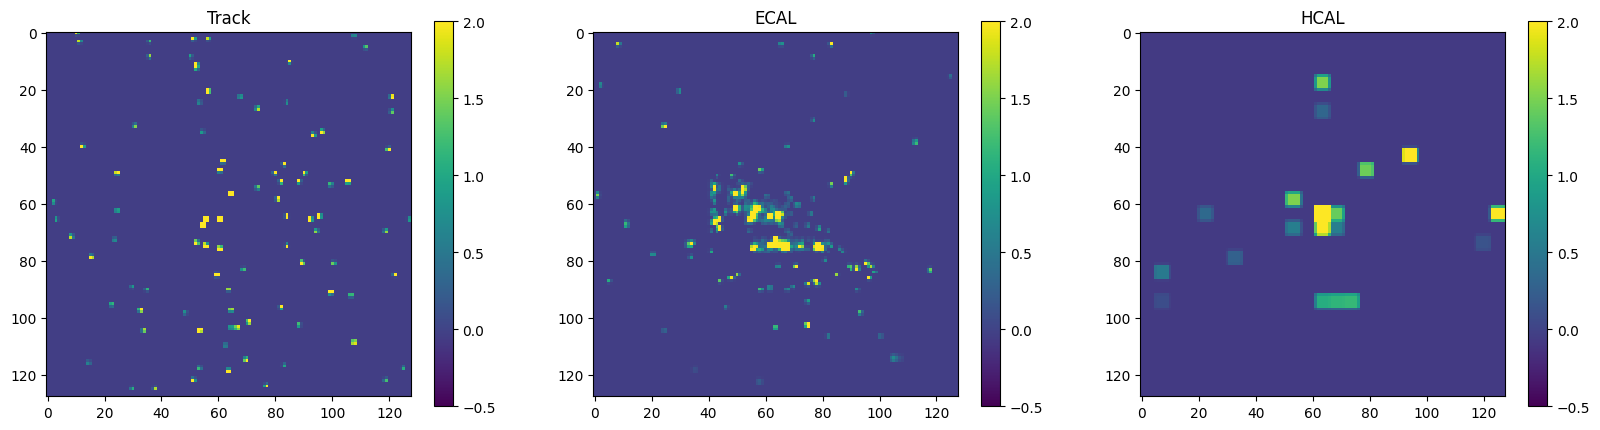

In [17]:
# Plotting the images of the 3 different channels(Track, ECAL,HCAL)
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

im1 = axs[0].imshow(norm_t[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[0].set_title('Track')

im2 = axs[1].imshow(norm_e[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[1].set_title('ECAL')

im3 = axs[2].imshow(norm_h[0], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
axs[2].set_title('HCAL')

# Add colorbars
fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

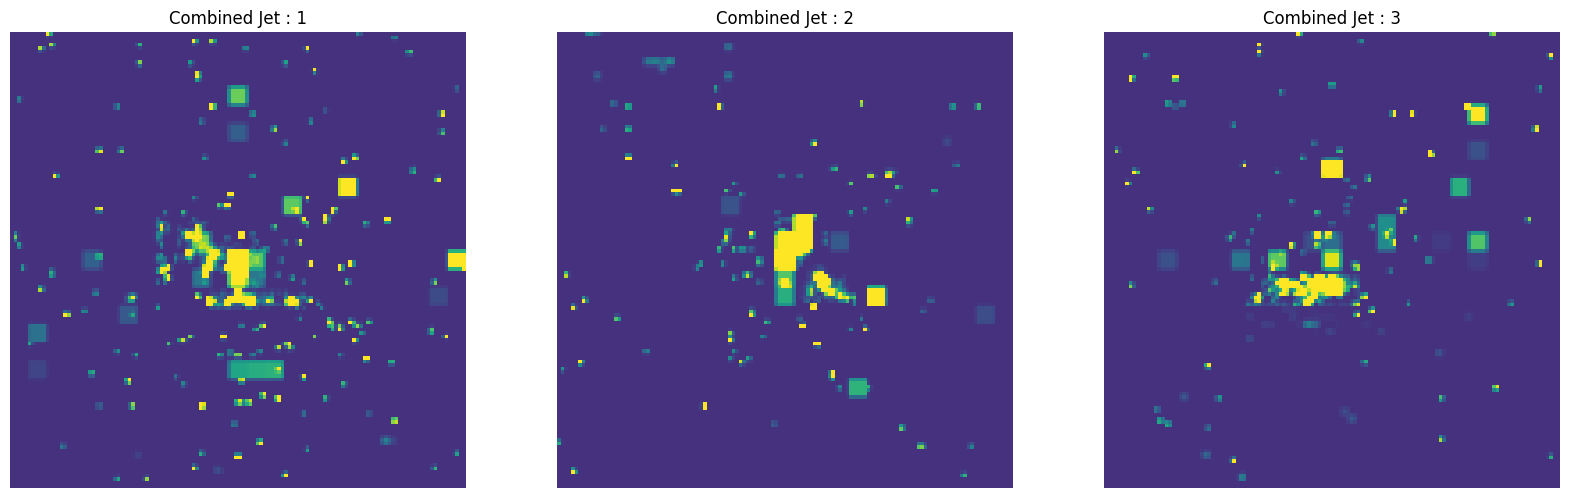

In [20]:
img_num = 3
# Plotting the Images of the combined channels
fig, axes = plt.subplots(1, img_num, figsize = (20,20))
for i in range(img_num):
    temp = axes[i].imshow(combined[i], cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('Combined Jet : {}'.format(i+1))
    fig.colorbar(temp, ax=axs[i], shrink=0.25)

In [20]:
# creating train and test and validation dataloaders
batch_size = 16
train_loader = DataLoader(X_jets[:4000], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_jets[4000:4500], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_jets[4500:], batch_size=batch_size, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Building The VAE model

In [22]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 1024),
            nn.ReLU()
        )

        # Latent space representation
        self.z_mean = nn.Linear(1024, latent_dim)
        self.z_log_var = nn.Linear(1024, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 16 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def sampling(self, mu, sigma):
        # Generates a random sample and combines with the encoder output
        batch = mu.shape[0]
        dim = mu.shape[1]
        epsilon = torch.randn(batch, dim, device=mu.device)
        z = mu + torch.exp(0.5 * sigma) * epsilon # reparameterization trick
        return z

    def forward(self, x):
        x = self.encoder(x)
        mu = self.z_mean(x)
        log_var = self.z_log_var(x)
        z = self.sampling(mu, log_var)
        z = self.decoder(z)
        return z, mu, log_var

In [23]:
# Defining loss function
def vae_loss(inputs, outputs, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(outputs, inputs) * 128 * 128 * 3
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_loss

# Training of the VAE Model

In [25]:
latent_dim = 1024
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_idx, x in enumerate(train_loader):
        x = x.to(device)
        x = x.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        train_loss = vae_loss(x, x_hat, mean, log_var)
        train_loss.backward()
        optimizer.step()
        epoch_train_loss += train_loss.item() * len(x)  # Accumulate loss for the epoch
    epoch_train_loss /= len(train_loader.dataset)  # Compute average loss for the epoch
    train_losses.append(epoch_train_loss)  # Store the epoch training loss

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, x in enumerate(val_loader):
            x = x.to(device)
            x = x.permute(0, 3, 1, 2)
            x_hat, mean, log_var = model(x)
            val_loss = vae_loss(x, x_hat, mean, log_var)
            epoch_val_loss += val_loss.item() * len(x)  # Accumulate loss for the epoch
    epoch_val_loss /= len(val_loader.dataset)  # Compute average loss for the epoch
    val_losses.append(epoch_val_loss)  # Store the epoch validation loss

    log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
    print(log.format(epoch+1, epoch_train_loss, epoch_val_loss))


Epoch 1, Train Loss: 770.654, Val Loss: 16.582
Epoch 2, Train Loss: 14.665, Val Loss: 13.200
Epoch 3, Train Loss: 12.309, Val Loss: 11.603
Epoch 4, Train Loss: 11.134, Val Loss: 10.744
Epoch 5, Train Loss: 10.428, Val Loss: 10.474
Epoch 6, Train Loss: 279.516, Val Loss: 70.502
Epoch 7, Train Loss: 47.921, Val Loss: 35.405
Epoch 8, Train Loss: 19.884, Val Loss: 15.201
Epoch 9, Train Loss: 13.561, Val Loss: 12.351
Epoch 10, Train Loss: 11.469, Val Loss: 10.915
Epoch 11, Train Loss: 10.543, Val Loss: 10.185
Epoch 12, Train Loss: 10.009, Val Loss: 9.833
Epoch 13, Train Loss: 9.725, Val Loss: 9.586
Epoch 14, Train Loss: 9.519, Val Loss: 9.497
Epoch 15, Train Loss: 9.422, Val Loss: 9.408
Epoch 16, Train Loss: 9.370, Val Loss: 9.355
Epoch 17, Train Loss: 9.329, Val Loss: 9.339
Epoch 18, Train Loss: 9.304, Val Loss: 9.296
Epoch 19, Train Loss: 9.284, Val Loss: 9.284
Epoch 20, Train Loss: 9.268, Val Loss: 9.287
Epoch 21, Train Loss: 9.249, Val Loss: 9.255
Epoch 22, Train Loss: 9.244, Val Loss: 

#Original v/s Reconstructed Event (VAE)

In [42]:
model.eval()
original_images = []
decoded_images = []

for _, inputs in enumerate(test_loader):
    inputs = inputs.to(device)
    inputs = inputs.permute(0, 3, 1, 2)  # Rearrange dimensions
    outputs,_,_ = model(inputs)
    original_images.append(inputs.detach().cpu())  # Movingthe input to CPU
    decoded_images.append(outputs.detach().cpu())  # Moving decoded outputs to CPU


# Concatenate images along the batch dimension
original_images = torch.cat(original_images)
decoded_images = torch.cat(decoded_images)

In [43]:
#Arranging the dimensions back to their original position
decoded_images = decoded_images.permute(0, 2, 3, 1)
original_images = original_images.permute(0, 2, 3, 1)

In [44]:
_, _, _, original_images = norm(np.array(original_images))
_, _, _, reconstructed_images = norm(np.array(decoded_images))

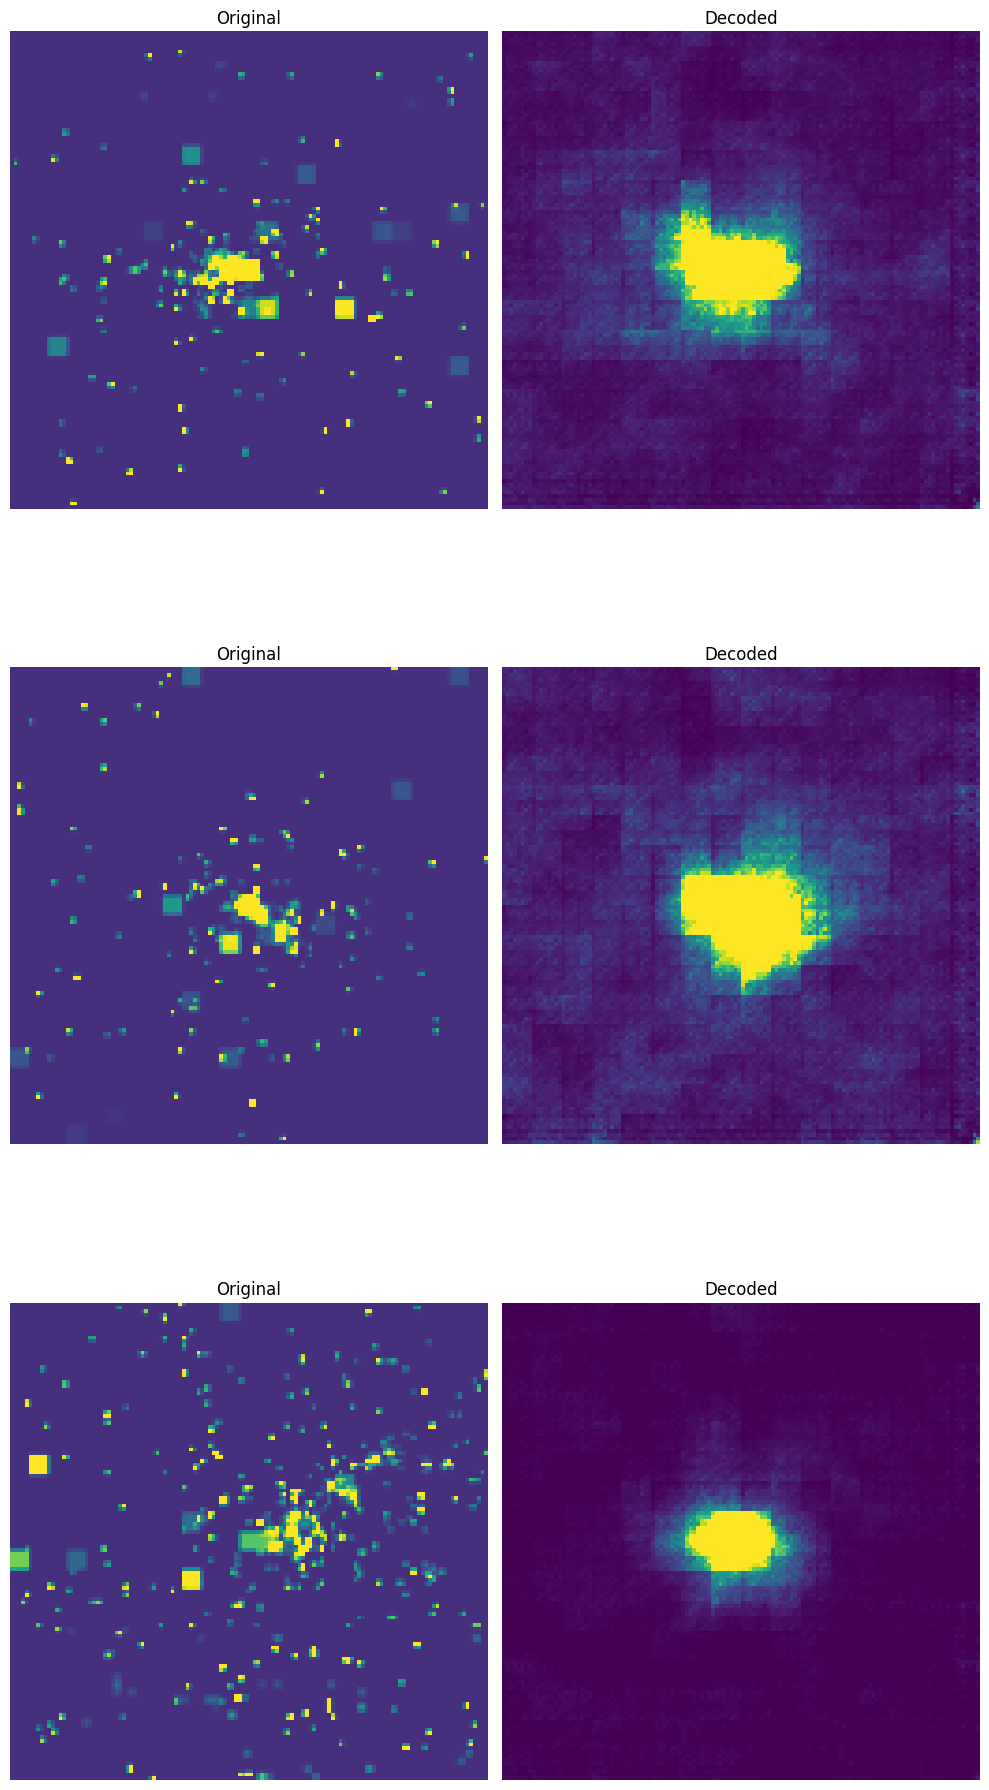

In [45]:
# Visualizing original and decoded images side by side
num_images = 3
fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

for i in range(num_images):
    # Display original image
    axes[i, 0].imshow(original_images[i],cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    # Display decoded image
    axes[i, 1].imshow(reconstructed_images[i],cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i, 1].set_title("Decoded")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Loss Plotting (VAE)

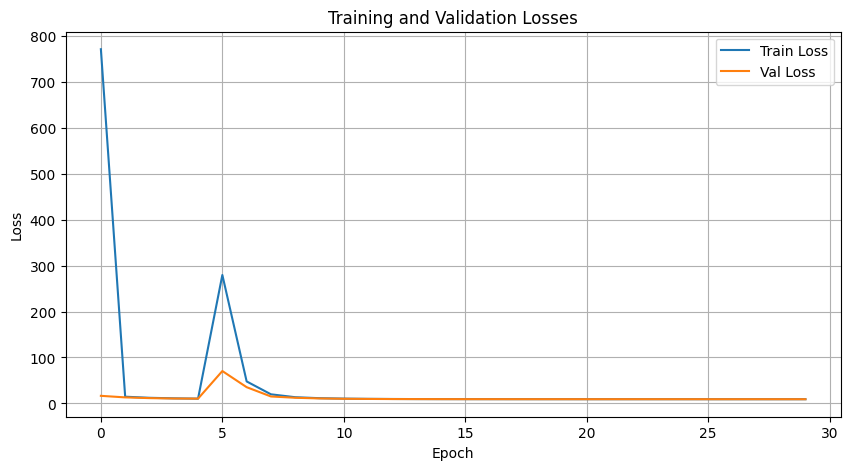

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

#Building the Beta - VAE Model

In [52]:
def beta_vae_loss(inputs, outputs, mu, log_var, beta = 1.5):
    reconstruction_loss = nn.functional.binary_cross_entropy(outputs, inputs) * 128 * 128 * 3
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + beta * kl_loss

In [53]:
class VAE_2(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_2, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 1024),
            nn.ReLU()
        )

        # Latent space representation
        self.z_mean = nn.Linear(1024, latent_dim)
        self.z_log_var = nn.Linear(1024, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 16 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def sampling(self, mu, sigma):
        # Generates a random sample and combines with the encoder output
        batch = mu.shape[0]
        dim = mu.shape[1]
        epsilon = torch.randn(batch, dim, device=mu.device)
        z = mu + torch.exp(0.5 * sigma) * epsilon
        return z

    def forward(self, x):
        x = self.encoder(x)
        mu = self.z_mean(x)
        log_var = self.z_log_var(x)
        z = self.sampling(mu, log_var)
        z = self.decoder(z)
        return z, mu, log_var

#Training the Beta-VAE model

In [54]:
latent_dim = 1024
model_2 = VAE_2(latent_dim).to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
epochs = 30

train_losses_2 = []
val_losses_2 = []

for epoch in range(epochs):
    model_2.train()
    epoch_train_loss = 0.0
    for batch_idx, x in enumerate(train_loader):
        x = x.to(device)
        x = x.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        x_hat, mean, log_var = model_2(x)
        train_loss = beta_vae_loss(x, x_hat, mean, log_var)
        train_loss.backward()
        optimizer.step()
        epoch_train_loss += train_loss.item() * len(x)  # Accumulate loss for the epoch
    epoch_train_loss /= len(train_loader.dataset)  # Compute average loss for the epoch
    train_losses_2.append(epoch_train_loss)  # Store the epoch training loss

    model_2.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, x in enumerate(val_loader):
            x = x.to(device)
            x = x.permute(0, 3, 1, 2)
            x_hat, mean, log_var = model_2(x)
            val_loss = beta_vae_loss(x, x_hat, mean, log_var)
            epoch_val_loss += val_loss.item() * len(x)  # Accumulate loss for the epoch
    epoch_val_loss /= len(val_loader.dataset)  # Compute average loss for the epoch
    val_losses_2.append(epoch_val_loss)  # Store the epoch validation loss

    log = "Epoch {}, Train Loss: {:.3f}, Val Loss: {:.3f}"
    print(log.format(epoch+1, epoch_train_loss, epoch_val_loss))


Epoch 1, Train Loss: 654.032, Val Loss: 16.399
Epoch 2, Train Loss: 14.088, Val Loss: 12.519
Epoch 3, Train Loss: 12.033, Val Loss: 11.096
Epoch 4, Train Loss: 176.451, Val Loss: 85.217
Epoch 5, Train Loss: 331.395, Val Loss: 16.551
Epoch 6, Train Loss: 14.713, Val Loss: 12.958
Epoch 7, Train Loss: 11.585, Val Loss: 10.921
Epoch 8, Train Loss: 31.696, Val Loss: 27.007
Epoch 9, Train Loss: 13.196, Val Loss: 10.531
Epoch 10, Train Loss: 10.369, Val Loss: 10.241
Epoch 11, Train Loss: 10.086, Val Loss: 9.943
Epoch 12, Train Loss: 9.832, Val Loss: 9.719
Epoch 13, Train Loss: 9.606, Val Loss: 9.515
Epoch 14, Train Loss: 9.469, Val Loss: 9.417
Epoch 15, Train Loss: 9.392, Val Loss: 9.379
Epoch 16, Train Loss: 9.363, Val Loss: 9.359
Epoch 17, Train Loss: 9.342, Val Loss: 9.321
Epoch 18, Train Loss: 9.317, Val Loss: 9.343
Epoch 19, Train Loss: 9.295, Val Loss: 9.292
Epoch 20, Train Loss: 9.300, Val Loss: 9.342
Epoch 21, Train Loss: 9.285, Val Loss: 9.296
Epoch 22, Train Loss: 9.270, Val Loss: 9

#Original v/s Reconstructed Image(Beta VAE)

In [57]:
model_2.eval()
original_images_beta = []
decoded_images_beta = []

for _, inputs in enumerate(test_loader):
    inputs = inputs.to(device)
    inputs = inputs.permute(0, 3, 1, 2)  # Rearrange dimensions
    outputs,_,_ = model_2(inputs)
    original_images_beta.append(inputs.detach().cpu())  # Moving to CPU
    decoded_images_beta.append(outputs.detach().cpu())  # Moving decoded outputs to CPU


# Concatenate images along the batch dimension
original_images_beta = torch.cat(original_images_beta)
decoded_images_beta = torch.cat(decoded_images_beta)

In [59]:
#Arranging the dimensions back to their original position
decoded_images_beta = decoded_images_beta.permute(0, 2, 3, 1)
original_images_beta = original_images_beta.permute(0, 2, 3, 1)

In [60]:
_, _, _, original_images_beta = norm(np.array(original_images_beta))
_, _, _, reconstructed_images_beta = norm(np.array(decoded_images_beta))

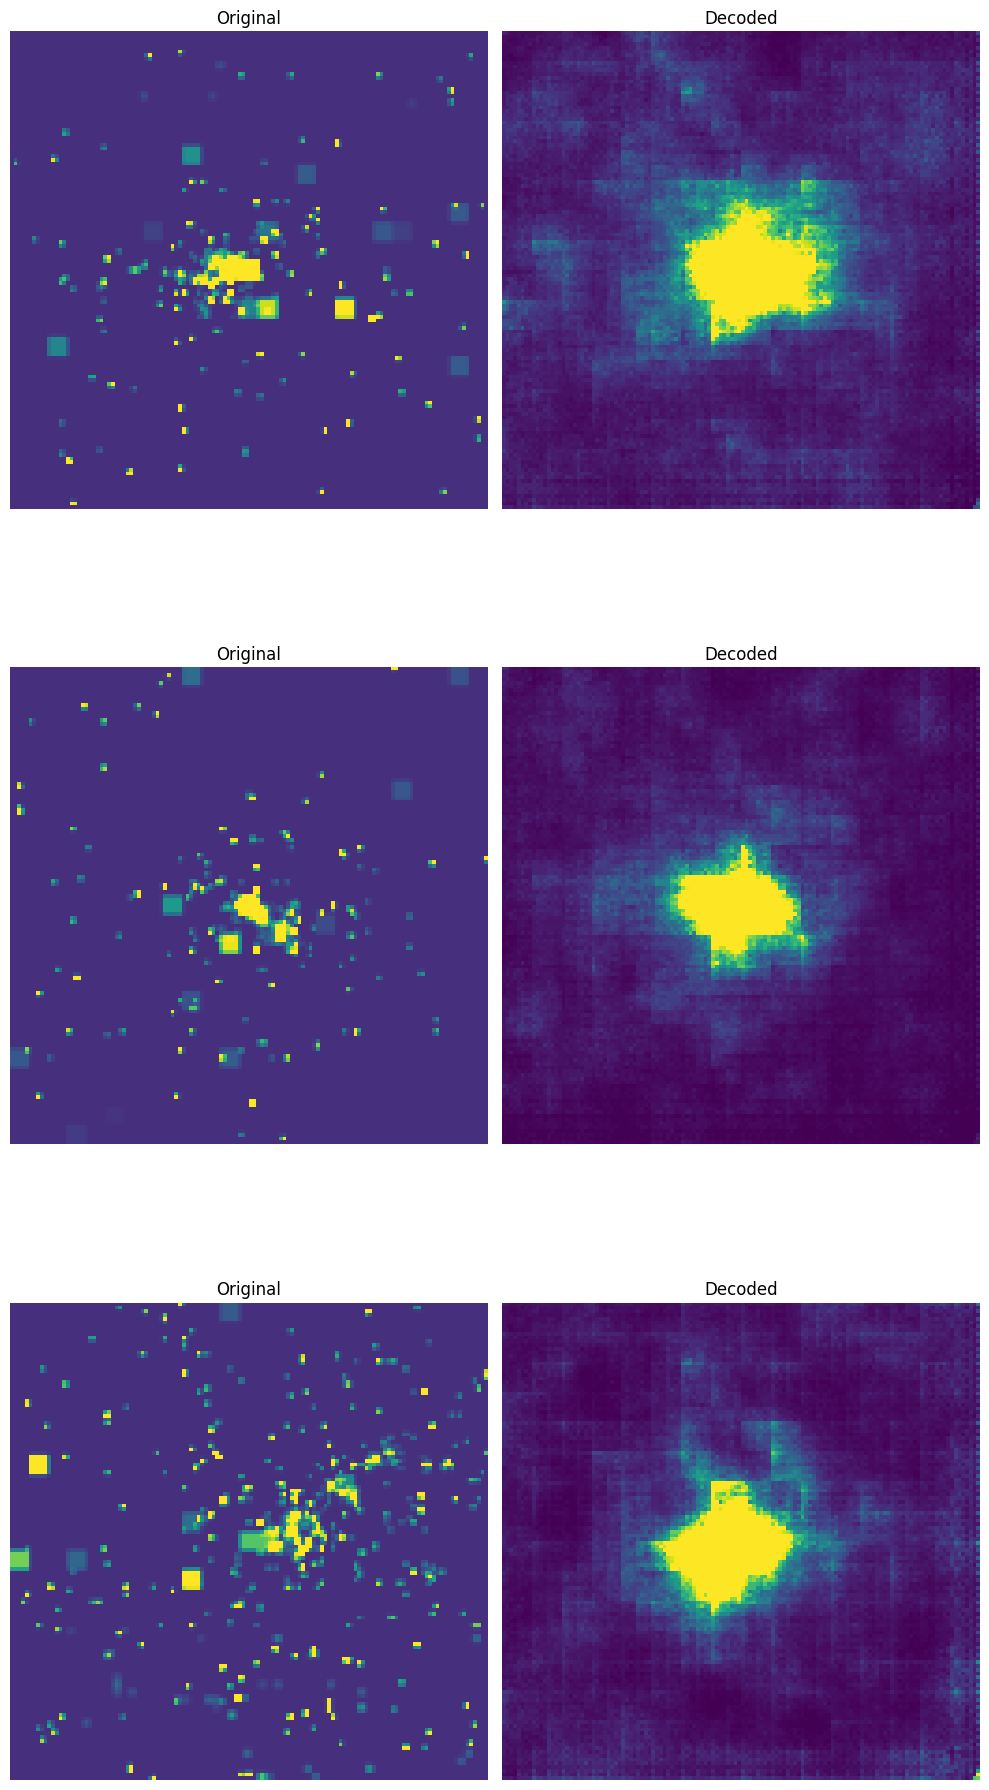

In [61]:
# Visualizing original and decoded images side by side
num_images = 3
fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

for i in range(num_images):
    # Display original image
    axes[i, 0].imshow(original_images_beta[i],cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    # Display decoded image
    axes[i, 1].imshow(reconstructed_images_beta[i],cmap = 'viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i, 1].set_title("Decoded")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

#Plotting Loss (Beta VAE)

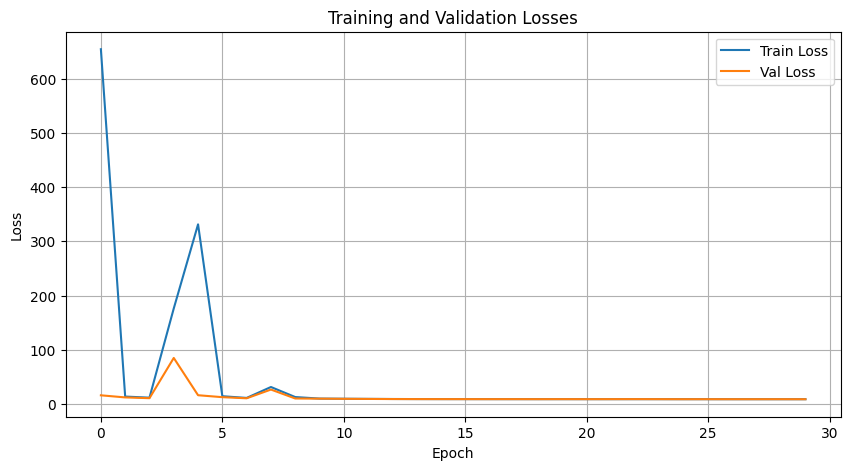

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_2, label='Train Loss')
plt.plot(val_losses_2, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion:

As it can be seen from above the generate images are not very good. So reasons for that can be:
1.   Since this is not typical RGB data the model does not behave in a way that it would for an RGB data.
2.   Although traditional transformations can be applied but there is not much difference. For Example, Rotating a image won't do us any good as the data is kind of rotation invariate. Similar for other transformations.
3. Since all of the dataset wasn't used so the training wasn't perfect. There may be a scope of Overfitting.
4. The hyperparameters may not be right and further fine tuning will be neccessary.
5. Using the Beta-VAE to understand the disentagled latent factore didn't helped. The reason may be data from all the channels may seem similar to the model.

Ways to improve the model:



1.   Other Architectures need to be explore.
2.   The hyperparamters should be tuned more.
3.   Other Generative models can be used to learn the representation such as Diffusion model etc.
4. Since the images are not the typical RGB images and based on research converting them to graph and applying Graph VAE may yield better results.